# This notebook tries to build and compare models on the same datasets, including transfer learning on ResNet

### Section 1: loads the image data

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from torchvision import transforms
from tempfile import TemporaryDirectory

In [2]:
# some data paarameters
imgdim = 224 # import images as 224x224
batch_size = 4
data_dir = "./hymenoptera_data"
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

In [3]:
# import images as tensors
transform = {"train": transforms.Compose([transforms.RandomResizedCrop(imgdim, antialias=True),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(img_mean, img_std)]),
             "val": transforms.Compose([transforms.Resize(256, antialias=True),
                                        transforms.CenterCrop(imgdim),
                                        transforms.ToTensor(),
                                        transforms.Normalize(img_mean, img_std)])}

datasets = {x: torchvision.datasets.ImageFolder(root=os.path.join(data_dir, x), transform=transform[x]) for x in ["train", "val"]}

In [4]:
# put datasets into dataloaders
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ["train", "val"]}

In [5]:
# get the list of classes
classes = datasets["train"].classes
print(classes)

['ants', 'bees']


In [6]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

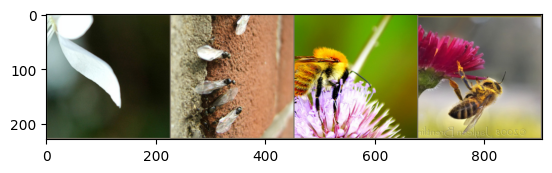

Classes:
bees ants bees bees


In [7]:
# show and review some images

# function to show an input image
def imshow(img, mean, std):
    """
    This function shows the actual image given the input pixel data

    Inputs:
        img: torch tensor
    """

    # convert to numpy and transpose
    npimg = img.numpy().transpose((1, 2, 0))

    # de-normalize
    npimg = npimg * std + mean
    npimg = np.clip(npimg, 0, 1)

    # show images
    plt.imshow(npimg)
    plt.show()
    
# get sample images
dataiter = iter(dataloaders["train"])
sample_inputs, sample_labels = next(dataiter)

# show images
sample_images = torchvision.utils.make_grid(sample_inputs)
imshow(sample_images, img_mean, img_std)
print("Classes:")
print(" ".join(classes[label] for label in sample_labels))

### Section 2: define training functions

In [8]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    """
    This function trains a given model on the train set, computes performance stats on both train and val, and saves the model with the best epoch level performances
    """

    since = time.time()

    with TemporaryDirectory() as tempdir:

        # save the model weights, and set it up for the saved weights to be updated 
        PATH = os.path.join(tempdir, "best_model_params.pt")
        torch.save(model.state_dict(), PATH)
        best_accuracy = 0.0

        # loop through epochs
        for epoch in range(num_epochs):

            print("Epoch: {epoch}/{num_epochs}".format(epoch=epoch, num_epochs=num_epochs-1))
            print("=" * 10)

            # each epoch has a train and a val phase
            for phase in ["train", "val"]:

                # initialize the model mode accordingly
                # TODO - Why is this step needed?
                model.train() if phase == "train" else model.eval()

                # initialize performance stats
                running_loss = 0.0
                running_corrects = 0

                # loop through the dataset
                for inputs, labels in dataloaders[phase]:

                    # move data to the proper device
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward prop
                    # perform gradient related tasks only if in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, predicts = torch.max(outputs, 1)

                        # backward prop and update weights only if in train
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # update performance stats
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(predicts==labels.data)

                # update the scheduler
                if phase == "train":
                    scheduler.step()

                # aggregate the epoch level states
                epoch_loss = running_loss / len(datasets[phase])
                epoch_accuracy = running_corrects / len(datasets[phase])
                print("{phase} loss: {epoch_loss:.4f} accuracy: {epoch_accuracy:.4f}".format(phase=phase, epoch_loss=epoch_loss, epoch_accuracy=epoch_accuracy))

                # update saved model weights if needed
                if phase=="val" and epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    torch.save(model.state_dict(), PATH)

            print()
            
        # print training stats
        time_elapsed = time.time() - since
        print("Training completed in {min:.0f}m {sec:.0f}s".format(min=(time_elapsed//60), sec=(time_elapsed%60)))
        print("Best val accuracy: {accuracy:.4f}".format(accuracy=best_accuracy))
        print()
        
        # load the best model
        model.load_state_dict(torch.load(PATH))
        
    return model

### Step 3: finetune a ResNet18 model

In [9]:
# get a pre-trained ResNet18 model 
model_ft = torchvision.models.resnet18(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/baiber/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [12]:
# replace the last layer of the original resnet18, also the only fc layer, by a new fc layer with the right number of output classes
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, len(classes))

In [13]:
# move the model to the right device
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# set the criterion/loss function for finetuning
criterion = nn.CrossEntropyLoss()

# set the optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
# train/finetune the model
model_ft = train_model(model=model_ft,
                       dataloaders=dataloaders,
                       criterion=criterion,
                       optimizer=optimizer_ft,
                       scheduler=exp_lr_scheduler,
                       num_epochs=25)

Epoch: 0/24
train loss: 0.6403 accuracy: 0.6557
val loss: 0.2644 accuracy: 0.8824

Epoch: 1/24
train loss: 0.4105 accuracy: 0.8115
val loss: 0.3599 accuracy: 0.8431

Epoch: 2/24
train loss: 0.5048 accuracy: 0.7910
val loss: 0.2403 accuracy: 0.9150

Epoch: 3/24
train loss: 0.3596 accuracy: 0.8320
val loss: 0.3635 accuracy: 0.8497

Epoch: 4/24
train loss: 0.4059 accuracy: 0.8484
val loss: 0.3008 accuracy: 0.8758

Epoch: 5/24
train loss: 0.4916 accuracy: 0.8115
val loss: 0.3022 accuracy: 0.8627

Epoch: 6/24
train loss: 0.4822 accuracy: 0.7869
val loss: 0.1550 accuracy: 0.9412

Epoch: 7/24
train loss: 0.3838 accuracy: 0.8484
val loss: 0.1825 accuracy: 0.9216

Epoch: 8/24
train loss: 0.2859 accuracy: 0.8852
val loss: 0.1626 accuracy: 0.9412

Epoch: 9/24
train loss: 0.2762 accuracy: 0.8770
val loss: 0.1665 accuracy: 0.9412

Epoch: 10/24
train loss: 0.3193 accuracy: 0.8484
val loss: 0.1642 accuracy: 0.9346

Epoch: 11/24
train loss: 0.3347 accuracy: 0.8607
val loss: 0.2258 accuracy: 0.9020

Ep